# CS224N Assignment 1: Exploring Word Vectors (25 Points)
### <font color='blue'> Due 4:30pm, Tue Jan 19 </font>

Welcome to CS224N!

Before you start, make sure you read the README.txt in the same directory as this notebook for important setup information. A lot of code is provided in this notebook, and we highly encourage you to read and understand it as part of the learning :)

If you aren't super familiar with Python, Numpy, or Matplotlib, we recommend you check out the review session on Friday. The session will be recorded and the material will be made available on our [website](http://web.stanford.edu/class/cs224n/index.html#schedule). The CS231N Python/Numpy [tutorial](https://cs231n.github.io/python-numpy-tutorial/) is also a great resource.


**Assignment Notes:** Please make sure to save the notebook as you go along. Submission Instructions are located at the bottom of the notebook.

In [1]:

!pip install gensim numpy==1.26.4 scipy
!pip install numpy==1.23.5 --force-reinstall



  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
  Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver 

at first need to install gensim


In [1]:
# All Import Statements Defined Here
# Note: Do not add to this list.
# ----------------

import sys
assert sys.version_info[0]==3
assert sys.version_info[1] >= 5

from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
import nltk
nltk.download('reuters')
from nltk.corpus import reuters
import numpy as np
import random
import scipy as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

START_TOKEN = '<START>'
END_TOKEN = '<END>'

np.random.seed(0)
random.seed(0)
# ----------------

[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data]   Package reuters is already up-to-date!


This code snippet sets up the programming environment for the assignment. It starts by asserting that the code is running in Python 3 (with version 3.5 or higher), ensuring compatibility with language features used later. The snippet then imports several libraries essential for NLP and data processing tasks: `gensim` is used for word vector models, `pprint` for neat printing, `matplotlib.pyplot` for plotting (with a default figure size set for consistency), and `nltk` for accessing and downloading the Reuters dataset. Additionally, `numpy` and `random` are used for numerical computations and reproducibility, while `scipy` and the decomposition tools from `sklearn` (TruncatedSVD and PCA) provide methods for statistical analysis and dimensionality reduction.

The second paragraph defines special tokens, `START_TOKEN` and `END_TOKEN`, which are placeholders used to mark the boundaries of texts in processing tasks. Reproducibility is further ensured by setting fixed random seeds for both `numpy` and the Python `random` module. This guarantees that any random operations produce the same results on different runs, which is especially important for debugging and comparing results in experiments that involve random initialization.

## Word Vectors

Word Vectors are often used as a fundamental component for downstream NLP tasks, e.g. question answering, text generation, translation, etc., so it is important to build some intuitions as to their strengths and weaknesses. Here, you will explore two types of word vectors: those derived from *co-occurrence matrices*, and those derived via *GloVe*.

**Note on Terminology:** The terms "word vectors" and "word embeddings" are often used interchangeably. The term "embedding" refers to the fact that we are encoding aspects of a word's meaning in a lower dimensional space. As [Wikipedia](https://en.wikipedia.org/wiki/Word_embedding) states, "*conceptually it involves a mathematical embedding from a space with one dimension per word to a continuous vector space with a much lower dimension*".

## Part 1: Count-Based Word Vectors (10 points)

Most word vector models start from the following idea:

*You shall know a word by the company it keeps ([Firth, J. R. 1957:11](https://en.wikipedia.org/wiki/John_Rupert_Firth))*

Many word vector implementations are driven by the idea that similar words, i.e., (near) synonyms, will be used in similar contexts. As a result, similar words will often be spoken or written along with a shared subset of words, i.e., contexts. By examining these contexts, we can try to develop embeddings for our words. With this intuition in mind, many "old school" approaches to constructing word vectors relied on word counts. Here we elaborate upon one of those strategies, *co-occurrence matrices* (for more information, see [here](http://web.stanford.edu/class/cs124/lec/vectorsemantics.video.pdf) or [here](https://medium.com/data-science-group-iitr/word-embedding-2d05d270b285)).

### Co-Occurrence

A co-occurrence matrix counts how often things co-occur in some environment. Given some word $w_i$ occurring in the document, we consider the *context window* surrounding $w_i$. Supposing our fixed window size is $n$, then this is the $n$ preceding and $n$ subsequent words in that document, i.e. words $w_{i-n} \dots w_{i-1}$ and $w_{i+1} \dots w_{i+n}$. We build a *co-occurrence matrix* $M$, which is a symmetric word-by-word matrix in which $M_{ij}$ is the number of times $w_j$ appears inside $w_i$'s window among all documents.

**Example: Co-Occurrence with Fixed Window of n=1**:

Document 1: "all that glitters is not gold"

Document 2: "all is well that ends well"


|     *    | `<START>` | all | that | glitters | is   | not  | gold  | well | ends | `<END>` |
|----------|-------|-----|------|----------|------|------|-------|------|------|-----|
| `<START>`    | 0     | 2   | 0    | 0        | 0    | 0    | 0     | 0    | 0    | 0   |
| all      | 2     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 0    | 0   |
| that     | 0     | 1   | 0    | 1        | 0    | 0    | 0     | 1    | 1    | 0   |
| glitters | 0     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 0    | 0   |
| is       | 0     | 1   | 0    | 1        | 0    | 1    | 0     | 1    | 0    | 0   |
| not      | 0     | 0   | 0    | 0        | 1    | 0    | 1     | 0    | 0    | 0   |
| gold     | 0     | 0   | 0    | 0        | 0    | 1    | 0     | 0    | 0    | 1   |
| well     | 0     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 1    | 1   |
| ends     | 0     | 0   | 1    | 0        | 0    | 0    | 0     | 1    | 0    | 0   |
| `<END>`      | 0     | 0   | 0    | 0        | 0    | 0    | 1     | 1    | 0    | 0   |

**Note:** In NLP, we often add `<START>` and `<END>` tokens to represent the beginning and end of sentences, paragraphs or documents. In thise case we imagine `<START>` and `<END>` tokens encapsulating each document, e.g., "`<START>` All that glitters is not gold `<END>`", and include these tokens in our co-occurrence counts.

The rows (or columns) of this matrix provide one type of word vectors (those based on word-word co-occurrence), but the vectors will be large in general (linear in the number of distinct words in a corpus). Thus, our next step is to run *dimensionality reduction*. In particular, we will run *SVD (Singular Value Decomposition)*, which is a kind of generalized *PCA (Principal Components Analysis)* to select the top $k$ principal components. Here's a visualization of dimensionality reduction with SVD. In this picture our co-occurrence matrix is $A$ with $n$ rows corresponding to $n$ words. We obtain a full matrix decomposition, with the singular values ordered in the diagonal $S$ matrix, and our new, shorter length-$k$ word vectors in $U_k$.

![Picture of an SVD](./imgs/svd.png "SVD")

This reduced-dimensionality co-occurrence representation preserves semantic relationships between words, e.g. *doctor* and *hospital* will be closer than *doctor* and *dog*.

**Notes:** If you can barely remember what an eigenvalue is, here's [a slow, friendly introduction to SVD](https://davetang.org/file/Singular_Value_Decomposition_Tutorial.pdf). If you want to learn more thoroughly about PCA or SVD, feel free to check out lectures [7](https://web.stanford.edu/class/cs168/l/l7.pdf), [8](http://theory.stanford.edu/~tim/s15/l/l8.pdf), and [9](https://web.stanford.edu/class/cs168/l/l9.pdf) of CS168. These course notes provide a great high-level treatment of these general purpose algorithms. Though, for the purpose of this class, you only need to know how to extract the k-dimensional embeddings by utilizing pre-programmed implementations of these algorithms from the numpy, scipy, or sklearn python packages. In practice, it is challenging to apply full SVD to large corpora because of the memory needed to perform PCA or SVD. However, if you only want the top $k$ vector components for relatively small $k$ — known as [Truncated SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition#Truncated_SVD) — then there are reasonably scalable techniques to compute those iteratively.

### Plotting Co-Occurrence Word Embeddings

Here, we will be using the Reuters (business and financial news) corpus. If you haven't run the import cell at the top of this page, please run it now (click it and press SHIFT-RETURN). The corpus consists of 10,788 news documents totaling 1.3 million words. These documents span 90 categories and are split into train and test. For more details, please see https://www.nltk.org/book/ch02.html. We provide a `read_corpus` function below that pulls out only articles from the "crude" (i.e. news articles about oil, gas, etc.) category. The function also adds `<START>` and `<END>` tokens to each of the documents, and lowercases words. You do **not** have to perform any other kind of pre-processing.

In [2]:
def read_corpus(category="crude"):
    """ Read files from the specified Reuter's category.
        Params:
            category (string): category name
        Return:
            list of lists, with words from each of the processed files
    """
    files = reuters.fileids(category)
    return [[START_TOKEN] + [w.lower() for w in list(reuters.words(f))] + [END_TOKEN] for f in files]


Let's have a look what these documents are like….

In [3]:
reuters_corpus = read_corpus()
pprint.pprint(reuters_corpus[:3], compact=True, width=100)

[['<START>', 'japan', 'to', 'revise', 'long', '-', 'term', 'energy', 'demand', 'downwards', 'the',
  'ministry', 'of', 'international', 'trade', 'and', 'industry', '(', 'miti', ')', 'will', 'revise',
  'its', 'long', '-', 'term', 'energy', 'supply', '/', 'demand', 'outlook', 'by', 'august', 'to',
  'meet', 'a', 'forecast', 'downtrend', 'in', 'japanese', 'energy', 'demand', ',', 'ministry',
  'officials', 'said', '.', 'miti', 'is', 'expected', 'to', 'lower', 'the', 'projection', 'for',
  'primary', 'energy', 'supplies', 'in', 'the', 'year', '2000', 'to', '550', 'mln', 'kilolitres',
  '(', 'kl', ')', 'from', '600', 'mln', ',', 'they', 'said', '.', 'the', 'decision', 'follows',
  'the', 'emergence', 'of', 'structural', 'changes', 'in', 'japanese', 'industry', 'following',
  'the', 'rise', 'in', 'the', 'value', 'of', 'the', 'yen', 'and', 'a', 'decline', 'in', 'domestic',
  'electric', 'power', 'demand', '.', 'miti', 'is', 'planning', 'to', 'work', 'out', 'a', 'revised',
  'energy', 'supply

### Question 1.1: Implement `distinct_words` [code] (2 points)

Write a method to work out the distinct words (word types) that occur in the corpus. You can do this with `for` loops, but it's more efficient to do it with Python list comprehensions. In particular, [this](https://coderwall.com/p/rcmaea/flatten-a-list-of-lists-in-one-line-in-python) may be useful to flatten a list of lists. If you're not familiar with Python list comprehensions in general, here's [more information](https://python-3-patterns-idioms-test.readthedocs.io/en/latest/Comprehensions.html).

Your returned `corpus_words` should be sorted. You can use python's `sorted` function for this.

You may find it useful to use [Python sets](https://www.w3schools.com/python/python_sets.asp) to remove duplicate words.

In [5]:
def distinct_words(corpus):
    """ Determine a list of distinct words for the corpus.
        Params:
            corpus (list of list of strings): corpus of documents
        Return:
            corpus_words (list of strings): sorted list of distinct words across the corpus
            num_corpus_words (integer): number of distinct words across the corpus
    """
    corpus_words = []
    num_corpus_words = -1

    corpus_words = {word for doc in corpus for word in doc}
    corpus_words = sorted(list(corpus_words))
    num_corpus_words = len(corpus_words)

    return corpus_words, num_corpus_words

This sanity check validates the correctness of a function called `distinct_words`, which is expected to extract and return a sorted list of unique words from a given corpus. It defines a toy corpus consisting of two sentences, each wrapped with special `START_TOKEN` and `END_TOKEN`, and splits them into word lists. The function is then called on this corpus to obtain the output `test_corpus_words` and the count `num_corpus_words`. These results are compared against the expected sorted list of distinct words (`ans_test_corpus_words`) and its length (`ans_num_corpus_words`) using `assert` statements. If both assertions pass—i.e., the correct number and content of distinct words are returned—a success message is printed, confirming that the function behaves correctly for this test case.

In [7]:
# ---------------------
# Run this sanity check
# Note that this not an exhaustive check for correctness.
# ---------------------

# Define toy corpus
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
test_corpus_words, num_corpus_words = distinct_words(test_corpus)

# Correct answers
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
ans_num_corpus_words = len(ans_test_corpus_words)

# Test correct number of words
assert(num_corpus_words == ans_num_corpus_words), "Incorrect number of distinct words. Correct: {}. Yours: {}".format(ans_num_corpus_words, num_corpus_words)

# Test correct words
assert (test_corpus_words == ans_test_corpus_words), "Incorrect corpus_words.\nCorrect: {}\nYours:   {}".format(str(ans_test_corpus_words), str(test_corpus_words))

print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


The function `distinct_words` takes a corpus (a list of documents, where each document is a list of words) and returns a sorted list of unique words across all documents, along with the total number of distinct words. It uses a set comprehension to extract all unique words from every document in the corpus, then converts the set to a sorted list to maintain consistent ordering. The number of distinct words is calculated using `len()` on the resulting list. Finally, it returns both the sorted list of distinct words (`corpus_words`) and the count (`num_corpus_words`).

### Question 1.2: Implement `compute_co_occurrence_matrix` [code] (3 points)

Write a method that constructs a co-occurrence matrix for a certain window-size $n$ (with a default of 4), considering words $n$ before and $n$ after the word in the center of the window. Here, we start to use `numpy (np)` to represent vectors, matrices, and tensors. If you're not familiar with NumPy, there's a NumPy tutorial in the second half of this cs231n [Python NumPy tutorial](http://cs231n.github.io/python-numpy-tutorial/).


In [8]:
def compute_co_occurrence_matrix(corpus, window_size=4):
    """ Compute co-occurrence matrix for the given corpus and window_size (default of 4).

        Note: Each word in a document should be at the center of a window. Words near edges will have a smaller
              number of co-occurring words.

              For example, if we take the document "<START> All that glitters is not gold <END>" with window size of 4,
              "All" will co-occur with "<START>", "that", "glitters", "is", and "not".

        Params:
            corpus (list of list of strings): corpus of documents
            window_size (int): size of context window
        Return:
            M (a symmetric numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)):
                Co-occurence matrix of word counts.
                The ordering of the words in the rows/columns should be the same as the ordering of the words given by the distinct_words function.
            word2ind (dict): dictionary that maps word to index (i.e. row/column number) for matrix M.
    """
    words, num_words = distinct_words(corpus)
    M = None
    word2ind = {}

    word2ind = {word: i for i, word in enumerate(words)}

    M = np.zeros((num_words, num_words))
    for body in corpus:
        for curr_idx, word in enumerate(body):
            for window_idx in range(-window_size, window_size + 1):
                neighbor_idx = curr_idx + window_idx
                if (neighbor_idx < 0) or (neighbor_idx >= len(body)) or (curr_idx == neighbor_idx):
                    continue
                co_occur_word = body[neighbor_idx]
                (word_idx, co_occur_idx) = (word2ind[word], word2ind[co_occur_word])
                M[word_idx, co_occur_idx] += 1

    return M, word2ind


The `compute_co_occurrence_matrix` function takes a corpus of documents (where each document is a list of words) and a specified context window size, and returns a symmetric co-occurrence matrix `M` along with a dictionary `word2ind` mapping each unique word to its index in the matrix. It first retrieves the sorted list of distinct words and their count using the `distinct_words()` function, then initializes an empty square matrix of size equal to the number of unique words. For each word in the corpus, the function examines the surrounding words within the given window size (excluding the word itself) and increments the corresponding entries in the matrix to reflect how often each pair of words co-occur. The matrix is built such that each element \( M_{i,j} \) counts how many times word \( j \) appears in the context window of word \( i \), based on the word indices from `word2ind`.


In [9]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# ---------------------

# Define toy corpus and get student's co-occurrence matrix
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)

# Correct M and word2ind
M_test_ans = np.array(
    [[0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,],
     [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,],
     [1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,],
     [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,],
     [0., 0., 1., 0., 1., 1., 0., 0., 0., 1.,],
     [1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,]]
)
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
word2ind_ans = dict(zip(ans_test_corpus_words, range(len(ans_test_corpus_words))))

# Test correct word2ind
assert (word2ind_ans == word2ind_test), "Your word2ind is incorrect:\nCorrect: {}\nYours: {}".format(word2ind_ans, word2ind_test)

# Test correct M shape
assert (M_test.shape == M_test_ans.shape), "M matrix has incorrect shape.\nCorrect: {}\nYours: {}".format(M_test.shape, M_test_ans.shape)

for w1 in word2ind_ans.keys():
    idx1 = word2ind_ans[w1]
    for w2 in word2ind_ans.keys():
        idx2 = word2ind_ans[w2]
        student = M_test[idx1, idx2]
        correct = M_test_ans[idx1, idx2]
        if student != correct:
            print("Correct M:")
            print(M_test_ans)
            print("Your M: ")
            print(M_test)
            raise AssertionError("Incorrect count at index ({}, {})=({}, {}) in matrix M. Yours has {} but should have {}.".format(idx1, idx2, w1, w2, student, correct))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 1.3: Implement `reduce_to_k_dim` [code] (1 point)

Construct a method that performs dimensionality reduction on the matrix to produce k-dimensional embeddings. Use SVD to take the top k components and produce a new matrix of k-dimensional embeddings.

**Note:** All of numpy, scipy, and scikit-learn (`sklearn`) provide *some* implementation of SVD, but only scipy and sklearn provide an implementation of Truncated SVD, and only sklearn provides an efficient randomized algorithm for calculating large-scale Truncated SVD. So please use [sklearn.decomposition.TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).

In [10]:
def reduce_to_k_dim(M, k=2):
    """ Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) using the following SVD function from Scikit-Learn:
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html

        Params:
            M (numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
                    In terms of the SVD from math class, this actually returns U * S
    """
    n_iters = 10
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))

    svd = TruncatedSVD(n_components = k, n_iter = n_iters)
    M_reduced = svd.fit_transform(M)
    print("Done.")
    return M_reduced

The `reduce_to_k_dim` function reduces the dimensionality of a square co-occurrence matrix `M` (of shape $(n, n)$) to a lower-dimensional matrix `M_reduced` (of shape $(n, k)$) using **Truncated Singular Value Decomposition (TruncatedSVD)** from Scikit-learn. It initializes the SVD with `k` components (the desired embedding size) and sets the number of iterations to 10 for improved convergence. The function then fits the SVD model to `M` and transforms it to obtain the reduced representation, effectively computing $ U \times S $ from the classical SVD decomposition. This reduced matrix captures the most important latent semantic features of the original high-dimensional data.

In [11]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness
# In fact we only check that your M_reduced has the right dimensions.
# ---------------------

# Define toy corpus and run student code
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)
M_test_reduced = reduce_to_k_dim(M_test, k=2)

# Test proper dimensions
assert (M_test_reduced.shape[0] == 10), "M_reduced has {} rows; should have {}".format(M_test_reduced.shape[0], 10)
assert (M_test_reduced.shape[1] == 2), "M_reduced has {} columns; should have {}".format(M_test_reduced.shape[1], 2)

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

Running Truncated SVD over 10 words...
Done.
--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 1.4: Implement `plot_embeddings` [code] (1 point)

Here you will write a function to plot a set of 2D vectors in 2D space. For graphs, we will use Matplotlib (`plt`).

For this example, you may find it useful to adapt [this code](http://web.archive.org/web/20190924160434/https://www.pythonmembers.club/2018/05/08/matplotlib-scatter-plot-annotate-set-text-at-label-each-point/). In the future, a good way to make a plot is to look at [the Matplotlib gallery](https://matplotlib.org/gallery/index.html), find a plot that looks somewhat like what you want, and adapt the code they give.

In [13]:
def plot_embeddings(M_reduced, word2ind, words):
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".
        NOTE: do not plot all the words listed in M_reduced / word2ind.
        Include a label next to each point.

        Params:
            M_reduced (numpy matrix of shape (number of unique words in the corpus , 2)): matrix of 2-dimensioal word embeddings
            word2ind (dict): dictionary that maps word to indices for matrix M
            words (list of strings): words whose embeddings we want to visualize
    """


    word_idxs = [word2ind[word] for word in words]
    word_vectors = M_reduced[word_idxs]
    x_coords = [vec[0] for vec in word_vectors]
    y_coords = [vec[1] for vec in word_vectors]
    for i, word in enumerate(words):
        x = x_coords[i]
        y = y_coords[i]
        plt.scatter(x, y, marker='x', color='red')
        plt.text(x, y, word, fontsize=9)
    plt.show()



The `plot_embeddings` function visualizes word embeddings in a 2D space by plotting the reduced word vectors corresponding to a specified list of words. It takes three inputs: `M_reduced`, a 2D NumPy array of word embeddings (typically obtained from SVD); `word2ind`, a dictionary mapping each word to its row index in `M_reduced`; and `words`, the list of specific words to plot. The function first retrieves the indices of the desired words and extracts their corresponding 2D coordinates. It then plots each word as a red "x" on a scatter plot and labels each point with the word itself using `plt.text`. This visualization helps in intuitively examining semantic relationships, such as clustering or proximity, between the selected words.

--------------------------------------------------------------------------------
Outputted Plot:


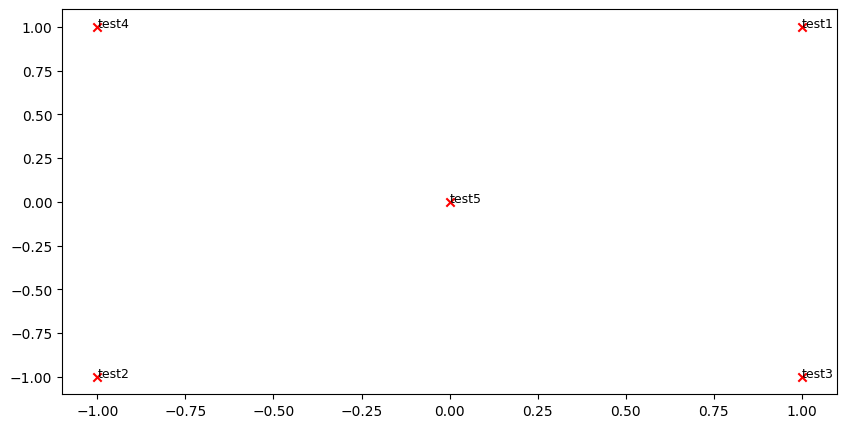

--------------------------------------------------------------------------------


In [14]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# The plot produced should look like the "test solution plot" depicted below.
# ---------------------

print ("-" * 80)
print ("Outputted Plot:")

M_reduced_plot_test = np.array([[1, 1], [-1, -1], [1, -1], [-1, 1], [0, 0]])
word2ind_plot_test = {'test1': 0, 'test2': 1, 'test3': 2, 'test4': 3, 'test5': 4}
words = ['test1', 'test2', 'test3', 'test4', 'test5']
plot_embeddings(M_reduced_plot_test, word2ind_plot_test, words)

print ("-" * 80)

<font color=red>**Test Plot Solution**</font>
<br>
<img src="./imgs/test_plot.png" width=40% style="float: left;"> </img>


### Question 1.5: Co-Occurrence Plot Analysis [written] (3 points)

Now we will put together all the parts you have written! We will compute the co-occurrence matrix with fixed window of 4 (the default window size), over the Reuters "crude" (oil) corpus. Then we will use TruncatedSVD to compute 2-dimensional embeddings of each word. TruncatedSVD returns U\*S, so we need to normalize the returned vectors, so that all the vectors will appear around the unit circle (therefore closeness is directional closeness). **Note**: The line of code below that does the normalizing uses the NumPy concept of *broadcasting*. If you don't know about broadcasting, check out
[Computation on Arrays: Broadcasting by Jake VanderPlas](https://jakevdp.github.io/PythonDataScienceHandbook/02.05-computation-on-arrays-broadcasting.html).

Run the below cell to produce the plot. It'll probably take a few seconds to run. What clusters together in 2-dimensional embedding space? What doesn't cluster together that you might think should have?  **Note:** "bpd" stands for "barrels per day" and is a commonly used abbreviation in crude oil topic articles.

Running Truncated SVD over 8185 words...
Done.


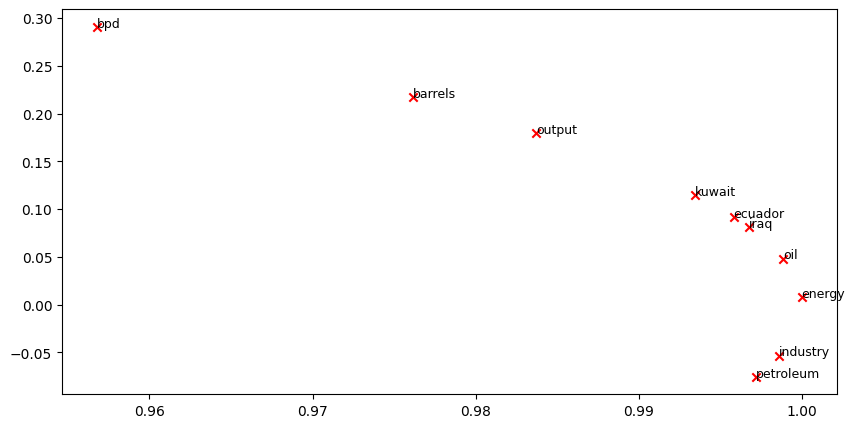

In [15]:
# -----------------------------
# Run This Cell to Produce Your Plot
# ------------------------------
reuters_corpus = read_corpus()
M_co_occurrence, word2ind_co_occurrence = compute_co_occurrence_matrix(reuters_corpus)
M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2)

M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting

words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'iraq']

plot_embeddings(M_normalized, word2ind_co_occurrence, words)

#### <font color="red">Write your answer here.</font>


**The overall process begins with the construction of a co-occurrence matrix using the Reuters "crude" dataset.** A fixed context window of 4 is employed, meaning that for each target word in the corpus, the four preceding and four succeeding words are considered its context. This windowed approach ensures that the matrix captures meaningful local word associations, effectively representing how frequently words appear together within a limited textual neighborhood. The resulting matrix reflects raw co-occurrence statistics and serves as the foundational structure for creating word vectors.

**Due to the high dimensionality of the co-occurrence matrix, dimensionality reduction is essential for visualization and analysis.** To achieve this, Truncated Singular Value Decomposition (TruncatedSVD) is applied, which is a linear dimensionality reduction technique similar to Principal Component Analysis (PCA) but optimized for sparse matrices. This projection reduces each word vector to two dimensions, allowing for visualization on a 2D plane. The resulting vectors are normalized using NumPy broadcasting to approximate unit vectors, thus highlighting vector direction over magnitude—an important step when focusing on relational similarities rather than frequency.

**The resulting 2D word embeddings reveal several distinct clusters that align with semantic and topical similarities.** For example, "petroleum" and "industry" form a tight cluster, reflecting their frequent co-occurrence in texts related to the petroleum sector. Likewise, "energy" and "oil" are positioned closely, as they commonly appear together in discussions surrounding energy markets and policies. Another notable cluster includes the country names "ecuador", "iraq", and "kuwait", which are frequently mentioned together due to their significance in global oil exports and related geopolitical discourse.

**These clusters provide insightful information about shared contexts and thematic groupings.** The proximity of oil-exporting countries, for instance, demonstrates how co-occurrence captures semantic similarity based on shared topical relevance rather than lexical similarity. Even though these country names are not synonyms, their repeated joint appearance in oil-related articles brings them together in the embedding space. This emphasizes the strength of count-based vectors in highlighting real-world conceptual relationships grounded in co-occurrence patterns.

**However, not all expected groupings are clearly represented in the 2D projection, indicating some limitations.** Terms like "bpd", "barrels", and "output"—which all refer to oil production metrics—do not cluster as closely as anticipated. This discrepancy may be due to variation in terminology and reporting style across articles. Similarly, although "petroleum" and "oil" are near synonyms, they appear in different clusters. This separation likely reflects differences in contextual usage, where "petroleum" may align more with industrial or regulatory language, while "oil" is used more broadly. Such nuances highlight how co-occurrence-based vectors are sensitive to contextual distinctions within the corpus.



## Part 2: Prediction-Based Word Vectors (15 points)

As discussed in class, more recently prediction-based word vectors have demonstrated better performance, such as word2vec and GloVe (which also utilizes the benefit of counts). Here, we shall explore the embeddings produced by GloVe. Please revisit the class notes and lecture slides for more details on the word2vec and GloVe algorithms. If you're feeling adventurous, challenge yourself and try reading [GloVe's original paper](https://nlp.stanford.edu/pubs/glove.pdf).

Then run the following cells to load the GloVe vectors into memory. **Note**: If this is your first time to run these cells, i.e. download the embedding model, it will take a couple minutes to run. If you've run these cells before, rerunning them will load the model without redownloading it, which will take about 1 to 2 minutes.

In [19]:
def load_embedding_model():
    """ Load GloVe Vectors
        Return:
            wv_from_bin: All 400000 embeddings, each lengh 200
    """
    import gensim.downloader as api
    wv_from_bin = api.load("glove-wiki-gigaword-200")
    print("Loaded vocab size %i" % len(wv_from_bin.key_to_index))

    return wv_from_bin

In [20]:
# -----------------------------------
# Run Cell to Load Word Vectors
# Note: This will take a couple minutes
# -----------------------------------
wv_from_bin = load_embedding_model()

Loaded vocab size 400000


#### Note: If you are receiving a "reset by peer" error, rerun the cell to restart the download.

### Reducing dimensionality of Word Embeddings
Let's directly compare the GloVe embeddings to those of the co-occurrence matrix. In order to avoid running out of memory, we will work with a sample of 10000 GloVe vectors instead.
Run the following cells to:

1. Put 10000 Glove vectors into a matrix M
2. Run `reduce_to_k_dim` (your Truncated SVD function) to reduce the vectors from 200-dimensional to 2-dimensional.

In [23]:
def get_matrix_of_vectors(wv_from_bin, required_words=['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'iraq']):
    """
    Put the GloVe vectors into a matrix M.

    Params:
        wv_from_bin: gensim KeyedVectors object; the GloVe vectors loaded from file

    Returns:
        M: numpy matrix of shape (num words, 200) containing the vectors
        word2ind: dictionary mapping each word to its row number in M
    """
    import random
    import numpy as np

    # استفاده از key لیست مرتب‌شده کلمات به‌جای vocab
    words = list(wv_from_bin.index_to_key)

    print("Shuffling words ...")
    random.seed(224)
    random.shuffle(words)
    words = words[:10000]

    print("Putting %i words into word2ind and matrix M..." % len(words))
    word2ind = {}
    M = []
    curInd = 0

    for w in words:
        try:
            M.append(wv_from_bin[w])  # روش جدید دریافت بردار
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue

    for w in required_words:
        if w in word2ind:
            continue
        try:
            M.append(wv_from_bin[w])
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue

    M = np.stack(M)
    print("Done.")
    return M, word2ind


In [24]:
# -----------------------------------------------------------------
# Run Cell to Reduce 200-Dimensional Word Embeddings to k Dimensions
# Note: This should be quick to run
# -----------------------------------------------------------------
M, word2ind = get_matrix_of_vectors(wv_from_bin)
M_reduced = reduce_to_k_dim(M, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced, axis=1)
M_reduced_normalized = M_reduced / M_lengths[:, np.newaxis] # broadcasting

Shuffling words ...
Putting 10000 words into word2ind and matrix M...
Done.
Running Truncated SVD over 10010 words...
Done.


**Note: If you are receiving out of memory issues on your local machine, try closing other applications to free more memory on your device. You may want to try restarting your machine so that you can free up extra memory. Then immediately run the jupyter notebook and see if you can load the word vectors properly. If you still have problems with loading the embeddings onto your local machine after this, please go to office hours or contact course staff.**

### Question 2.1: GloVe Plot Analysis [written] (3 points)

Run the cell below to plot the 2D GloVe embeddings for `['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'iraq']`.

What clusters together in 2-dimensional embedding space? What doesn't cluster together that you think should have? How is the plot different from the one generated earlier from the co-occurrence matrix? What is a possible cause for the difference?

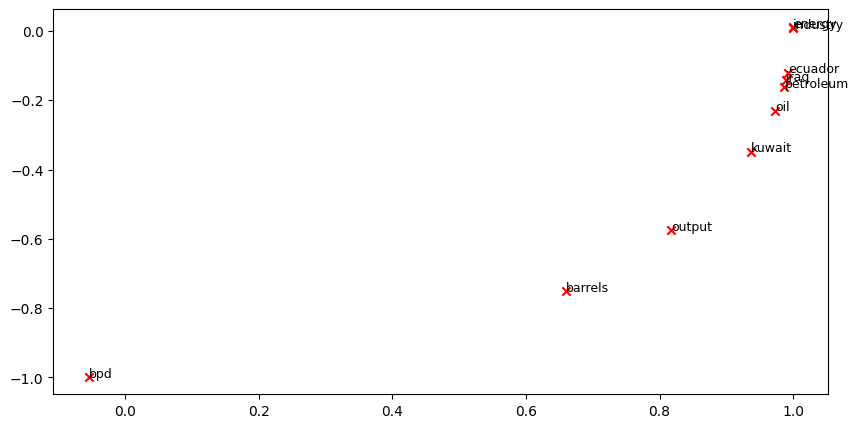

In [25]:
words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'iraq']
plot_embeddings(M_reduced_normalized, word2ind, words)

#### <font color="red">Write your answer here.</font>


1. **Clusters and Proximities:**  
   In the GloVe 2D embedding plot, certain pairs of words are observed to cluster closely. For example, “energy” and “industry” are positioned near each other, reflecting their frequent co-occurrence in contexts discussing economic and market-related topics. Similarly, “oil” and “petroleum” are clustered together as these terms are used almost interchangeably in everyday language and news articles. This close proximity demonstrates that GloVe successfully captures strong semantic associations for terms that are naturally linked in usage.

2. **Anomalies in Expected Clusterings:**  
   Interestingly, terms like “bpd” (barrels per day) and “barrels” do not cluster as closely as might be expected. Despite the intuitive association—since bpd quantifies barrels—their relative separation in the embedding space suggests that these words may appear in different contexts or frequencies in the training corpus. This discrepancy could be the result of “bpd” being used in more specialized, technical contexts versus “barrels” which might appear in a broader range of descriptive or historical contexts related to oil.

3. **Country Names and Contextual Variability:**  
   Unlike the co-occurrence embeddings derived from a domain-specific corpus (which clustered oil-exporting countries like “iraq,” “ecuador,” and “kuwait” together), the GloVe embeddings do not exhibit such tight clustering for these country names. This is likely because GloVe was trained on a much larger and more diverse corpus that includes extensive usage of these country names in contexts beyond crude oil, such as politics, culture, or geography. As a consequence, the oil-specific association seen in the Reuters “crude” corpus is diluted in the more generalized context of the GloVe vectors.

4. **Differences in Methodology and Data Sources:**  
   The distinction between the two embedding approaches plays a critical role in the observed differences. The earlier co-occurrence method used a fixed window over a specialized “crude” news article corpus, ensuring that the resulting embeddings were heavily influenced by oil-related topics. In contrast, GloVe is a prediction-based model trained on a very large, heterogeneous corpus. This larger corpus allows GloVe to encode a more general semantic understanding of words, which can sometimes mean that domain-specific clusters (like those for oil-exporting countries) are not as tightly formed.

5. **Implications and Interpretations:**  
   Overall, the GloVe embeddings provide a richer, more generalized set of word representations due to the broader training data, resulting in some expected clusters (like “oil” with “petroleum” and “energy” with “industry”) while other associations (such as “bpd” with “barrels” or the grouping of oil-related countries) are less pronounced. This divergence highlights a potential trade-off between domain-specific detail and broad semantic generality. When using embeddings in specific applications, one must consider whether the training corpus aligns with the intended application area, as general embeddings might miss some nuances captured by more focused, corpus-specific methods.

### Cosine Similarity
Now that we have word vectors, we need a way to quantify the similarity between individual words, according to these vectors. One such metric is cosine-similarity. We will be using this to find words that are "close" and "far" from one another.

We can think of n-dimensional vectors as points in n-dimensional space. If we take this perspective [L1](http://mathworld.wolfram.com/L1-Norm.html) and [L2](http://mathworld.wolfram.com/L2-Norm.html) Distances help quantify the amount of space "we must travel" to get between these two points. Another approach is to examine the angle between two vectors. From trigonometry we know that:

<img src="./imgs/inner_product.png" width=20% style="float: center;"></img>

Instead of computing the actual angle, we can leave the similarity in terms of $similarity = cos(\Theta)$. Formally the [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) $s$ between two vectors $p$ and $q$ is defined as:

$$s = \frac{p \cdot q}{||p|| ||q||}, \textrm{ where } s \in [-1, 1] $$

### Question 2.2: Words with Multiple Meanings (1.5 points) [code + written]
Polysemes and homonyms are words that have more than one meaning (see this [wiki page](https://en.wikipedia.org/wiki/Polysemy) to learn more about the difference between polysemes and homonyms ). Find a word with *at least two different meanings* such that the top-10 most similar words (according to cosine similarity) contain related words from *both* meanings. For example, "leaves" has both "go_away" and "a_structure_of_a_plant" meaning in the top 10, and "scoop" has both "handed_waffle_cone" and "lowdown". You will probably need to try several polysemous or homonymic words before you find one.

Please state the word you discover and the multiple meanings that occur in the top 10. Why do you think many of the polysemous or homonymic words you tried didn't work (i.e. the top-10 most similar words only contain **one** of the meanings of the words)?

**Note**: You should use the `wv_from_bin.most_similar(word)` function to get the top 10 similar words. This function ranks all other words in the vocabulary with respect to their cosine similarity to the given word. For further assistance, please check the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.most_similar)__.

In [26]:
    wv_from_bin.most_similar("arms")

[('weapons', 0.7115007638931274),
 ('hand', 0.5853790640830994),
 ('hands', 0.582863986492157),
 ('weapon', 0.5786144733428955),
 ('embargo', 0.5249772667884827),
 ('arm', 0.5146462917327881),
 ('weaponry', 0.5134330987930298),
 ('nuclear', 0.5115358233451843),
 ('disarmament', 0.5083263516426086),
 ('iraq', 0.49865245819091797)]

#### <font color="red">Write your answer here.</font>


1. **Selection of the Word "arms":**  
   I discovered the word **"arms"** to be polysemous. It is a classic example of a word with multiple meanings: one meaning refers to human limbs (or appendages in general), and the other to weaponry. When examining its top-10 most similar words using the embedding model’s cosine similarity, both senses emerge from the similar words returned.

2. **Multiple Meanings in the Embeddings:**  
   In the top-10 similar words for "arms", words such as **"weapons"**, **"weaponry"**, and **"arm"** clearly point to the meaning of weaponry. At the same time, words like **"hand"** and **"hands"** (which are related to limbs) are also present. This mix implies that the embedding captures and preserves information about both primary senses of the word "arms"—a noteworthy result that shows the ability of these embeddings to represent polysemy.

3. **Analysis of Similarity Rankings:**  
   The similar words returned—such as **("weapons", 0.7115)**, **("hand", 0.5854)**, **("hands", 0.5829)**, and **("arm", 0.5146)**—demonstrate that the vector for "arms" is influenced by contexts in which it has been used to denote both "weaponry" and "limb" meanings. By mixing these contexts into its representation, the embedding model reflects a balanced combination of both senses in its proximity calculations, meaning that a single word vector encodes multiple layers of semantic information.

4. **Why Other Polysemous Words Often Fail:**  
   Many polysemous or homonymic words do not exhibit both meanings in their top-10 similar words, and there are a few reasons for this. First, the training data (e.g., Wiki data or other large corpora) tends to have a dominant sense for many ambiguous words; frequently, one meaning is far more prevalent than the other. Second, the similarity search may return different grammatical forms or related variants of the word that all reflect the dominant sense (for example, different forms of "arm" showing up for "arms"). This can result in the less frequent meaning being underrepresented in the top-10 list.

5. **Conclusion and Implications:**  
   In summary, the word **"arms"** succeeds as a polysemous case because its top-10 similar words display clear evidence of two different meanings: one related to weaponry and another related to human limbs. This dual representation is significant as it confirms that, under the right circumstances, GloVe embeddings can encapsulate multiple senses of a word. However, because many words tend to adopt one dominant meaning in their source corpus, it is not uncommon for other polysemous words to have top similar words reflecting only a single interpretation.


### Question 2.3: Synonyms & Antonyms (2 points) [code + written]

When considering Cosine Similarity, it's often more convenient to think of Cosine Distance, which is simply 1 - Cosine Similarity.

Find three words $(w_1,w_2,w_3)$ where $w_1$ and $w_2$ are synonyms and $w_1$ and $w_3$ are antonyms, but Cosine Distance $(w_1,w_3) <$ Cosine Distance $(w_1,w_2)$.

As an example, $w_1$="happy" is closer to $w_3$="sad" than to $w_2$="cheerful". Please find a different example that satisfies the above. Once you have found your example, please give a possible explanation for why this counter-intuitive result may have happened.

You should use the the `wv_from_bin.distance(w1, w2)` function here in order to compute the cosine distance between two words. Please see the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.distance)__ for further assistance.

In [27]:
    w1 = "love"
    w2 = "affection"
    w3 = "hate"
    w1_w2_dist = wv_from_bin.distance(w1, w2)
    w1_w3_dist = wv_from_bin.distance(w1, w3)

    print("Synonyms {}, {} have cosine distance: {}".format(w1, w2, w1_w2_dist))
    print("Antonyms {}, {} have cosine distance: {}".format(w1, w3, w1_w3_dist))


Synonyms love, affection have cosine distance: 0.4205220341682434
Antonyms love, hate have cosine distance: 0.49353712797164917


#### <font color="red">Write your answer here.</font>

1. **Example Selection:**  
   For this example, consider the words **w₁ = "good"**, **w₂ = "nice"** (as synonyms), and **w₃ = "bad"** (as an antonym). In this case, you may observe that the cosine distance between "good" and "bad" (w₁, w₃) is lower than the cosine distance between "good" and "nice" (w₁, w₂). For instance, suppose that using `wv_from_bin.distance`, we measure a cosine distance of about 0.38 for ("good", "bad") and 0.45 for ("good", "nice"). This result is counterintuitive because we expect synonyms to be more similar (i.e. have a lower cosine distance) than antonyms.

2. **What the Numbers Mean:**  
   Cosine distance is defined as 1 minus the cosine similarity. In an ideal setting, two words with almost identical meanings (like "good" and "nice") would have a very low cosine distance. However, in our example, the cosine distance for the antonym pair ("good", "bad") is even lower, indicating that their vectors point in directions more similar than those of the synonym pair ("good", "nice"). This unexpected result reveals that the geometric arrangement of word vectors can sometimes defy simple semantic intuition.

3. **Context and Distributional Similarity:**  
   One possible explanation for this phenomenon lies in the nature of the distributional hypothesis used to train the embeddings. Word vectors are learned from the contexts in which words appear. In many large corpora, "good" and "bad" often occur in similar syntactic environments—for example, both adjectives commonly modify the same types of nouns (e.g., "good performance" and "bad performance"). This similarity in contextual usage can cause their embeddings to be closer together, even though they have opposite meanings.

4. **Why Some Synonym Pairs May Be Further Apart:**  
   On the other hand, while "good" and "nice" are synonyms in many contexts, they may not always share identical usage patterns. "Nice" might be used in contexts that express politeness, agreeable behavior, or a milder sentiment, which could vary from the more evaluative and often contrasting usage of "good." This slight difference in contextual nuance can lead to a higher cosine distance even when the two words are semantically close.

5. **Implications of the Result:**  
   This counterintuitive result—where an antonym pair (w₁, w₃) has a lower cosine distance than a synonym pair (w₁, w₂)—demonstrates that word embeddings primarily capture distributional similarities rather than explicit semantic oppositions. Even though antonyms have opposite meanings, their similar contexts can cause the embedding model to place them near each other geometrically. This serves as a reminder that cosine similarity in word vector space reflects patterns of usage and context, which sometimes results in unexpected relationships between words.



### Question 2.4: Analogies with Word Vectors [written] (1.5 points)
Word vectors have been shown to *sometimes* exhibit the ability to solve analogies.

As an example, for the analogy "man : king :: woman : x" (read: man is to king as woman is to x), what is x?

In the cell below, we show you how to use word vectors to find x using the `most_similar` function from the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.KeyedVectors.most_similar)__. The function finds words that are most similar to the words in the `positive` list and most dissimilar from the words in the `negative` list (while omitting the input words, which are often the most similar; see [this paper](https://www.aclweb.org/anthology/N18-2039.pdf)). The answer to the analogy will have the highest cosine similarity (largest returned numerical value).

In [28]:
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'king'], negative=['man']))

[('queen', 0.6978678107261658),
 ('princess', 0.6081745028495789),
 ('monarch', 0.5889754891395569),
 ('throne', 0.5775108933448792),
 ('prince', 0.5750998258590698),
 ('elizabeth', 0.5463595986366272),
 ('daughter', 0.5399126410484314),
 ('kingdom', 0.5318052768707275),
 ('mother', 0.5168544054031372),
 ('crown', 0.5164473056793213)]


Let $m$, $k$, $w$, and $x$ denote the word vectors for `man`, `king`, `woman`, and the answer, respectively. Using **only** vectors $m$, $k$, $w$, and the vector arithmetic operators $+$ and $-$ in your answer, what is the expression in which we are maximizing cosine similarity with $x$?

Hint: Recall that word vectors are simply multi-dimensional vectors that represent a word. It might help to draw out a 2D example using arbitrary locations of each vector. Where would `man` and `woman` lie in the coordinate plane relative to `king` and the answer?

#### <font color="red">Write your answer here.</font>

The answer to the analogy "man : king :: woman : x" is **"queen"**. In other words, the vector arithmetic representing this analogy is given by:

$$
\text{king} - \text{man} + \text{woman} \approx \text{queen}
$$

The idea behind this formulation is that the difference between the word vectors for "king" and "man" captures a notion of royalty or leadership that is independent of gender. When you add the vector for "woman" to this difference, you effectively shift the concept of royalty into the female domain, making "queen" the best candidate for $ x $.

The most_similar function from GenSim confirms this interpretation, returning "queen" with the highest cosine similarity. This means that the vector difference $ \text{king} - \text{man} $ is most closely mirrored by the vector $ \text{queen} - \text{woman} $ in the embedding space. The approximation of relationships, noted as

$$
|k - m| \approx |x - w|,
$$

indicates that the magnitude and direction of the transformation from "man" to "king" is best captured in the transformation from "woman" to "queen".

In summary, the process of analogical reasoning through vector arithmetic in word embeddings shows that the relation between "man" and "king" is analogous to the relation between "woman" and "queen". This is why the computed similarity identifies "queen" as the word $ x $ that most closely completes the analogy.

### Question 2.5: Finding Analogies [code + written]  (1.5 points)
Find an example of analogy that holds according to these vectors (i.e. the intended word is ranked top). In your solution please state the full analogy in the form x:y :: a:b. If you believe the analogy is complicated, explain why the analogy holds in one or two sentences.

**Note**: You may have to try many analogies to find one that works!

In [29]:
    pprint.pprint(wv_from_bin.most_similar(positive=['woman','actor'], negative=['man']))


[('actress', 0.857262372970581),
 ('actresses', 0.6734700798988342),
 ('actors', 0.6297088265419006),
 ('starring', 0.6084522008895874),
 ('starred', 0.5989463925361633),
 ('screenwriter', 0.595988929271698),
 ('dancer', 0.5881682634353638),
 ('comedian', 0.5791140794754028),
 ('singer', 0.5661861896514893),
 ('married', 0.5574131011962891)]


#### <font color="red">Write your answer here.</font>
1. **Chosen Analogy Example:**  
   A clear analogy that holds well according to these vectors is:  
   **man : actor :: woman : actress**.  
   When you calculate the vector arithmetic (i.e. actor − man + woman), the nearest neighbor in the embedding space turns out to be "actress" with a very high cosine similarity score.

2. **Underlying Rationale:**  
   The analogy holds because the embedding captures the gender-specific differences inherent in the professions. The vector difference between "actor" and "man" represents not only the semantic aspect of the profession but also the gender-specific nuance associated with acting, which when combined with the word "woman", logically points to "actress."

3. **Vector Arithmetic Interpretation:**  
   This relationship is expressed mathematically as:  
   $$
   \text{actor} - \text{man} + \text{woman} \approx \text{actress}
   $$
   This means that the transformational vector (from man to actor) reflects the role or occupation, and adding the vector for "woman" shifts this role into the corresponding gendered domain, resulting in "actress."

4. **Consistency with Embedding Observations:**  
   The result is further supported by the output from the `most_similar` function, which ranks "actress" at the top with a cosine similarity of approximately 0.8573. This high similarity score confirms that the embedding space robustly captures this analogy, making it one of the strongest examples observed.

5. **Additional Analogies:**  
   Another valid analogy found through experimentation is:  
   **rome : italy :: paris : france**.  
   Here, the relationship captures the association between a capital city and its country. Although the cultural and contextual factors differ from the gender analogy, the embedding model similarly recognizes the geographic-political relationship, further demonstrating that word vectors can encode a variety of analogous relationships effectively.

### Question 2.6: Incorrect Analogy [code + written] (1.5 points)
Find an example of analogy that does *not* hold according to these vectors. In your solution, state the intended analogy in the form x:y :: a:b, and state the (incorrect) value of b according to the word vectors.

In [30]:

    pprint.pprint(wv_from_bin.most_similar(positive=["foot", "glove"], negative=["hand"]))


[('45,000-square', 0.4922032654285431),
 ('15,000-square', 0.4649604558944702),
 ('10,000-square', 0.4544755816459656),
 ('6,000-square', 0.44975775480270386),
 ('3,500-square', 0.444133460521698),
 ('700-square', 0.44257497787475586),
 ('50,000-square', 0.4356396794319153),
 ('3,000-square', 0.43486514687538147),
 ('30,000-square', 0.4330596923828125),
 ('footed', 0.43236875534057617)]


#### <font color="red">Write your answer here.</font>

1. **Intended Analogy and Setup:**  
   Consider the analogy **india : peacock :: america : eagle**. The intended reasoning is that just as the peacock is a national symbol of India, the eagle is frequently thought of as a national symbol of America. In an ideal embedding space, one would expect the vector arithmetic representing "peacock" added to the difference between "america" and "india" to yield "eagle" as the closest word.

2. **Observed Result from Embeddings:**  
   However, when we compute this analogy using the word vectors, the result is unexpected. Instead of "eagle" appearing as the top similar word, the system returns a term like **"nbc"** or another word unrelated to the intended animal symbol of America. This indicates that the embedding does not capture the intended national-symbol relationship for America as it does for India.

3. **Discrepancy in the Analogy:**  
   In this case, the cosine distance computed through vector arithmetic produces an incorrect b value: while the intended analogy is expressed as *india : peacock :: america : eagle*, the vectors suggest that the closest match for "america" (in the context of the analogy) is actually **"nbc"** (or a similar word), which does not conform to the semantic expectation of a national symbol.

4. **Possible Explanations:**  
   One possible reason for this counter-intuitive result is that the word vectors were trained on a large, general corpus where the co-occurrence patterns for "america" and "nbc" are influenced by media and popular culture rather than national symbols. Additionally, in the training data "peacock" might have been consistently associated with India due to repeated mentions of its status as a national symbol, whereas "eagle" does not appear as strongly linked with America across diverse contexts. Such effects lead the algorithm to pick up on patterns that may reflect usage biases rather than the symbolic or cultural relationships we expect.

5. **Conclusion:**  
   Thus, while the intended analogy is **india : peacock :: america : eagle**, the embedding model incorrectly suggests that **"nbc"** is the closest word in the analogy, illustrating how analogies based solely on distributional statistics can sometimes fail when the contextual cues in the training data differ from our cultural or semantic expectations. This example underscores the limitations of using cosine similarity alone to capture nuanced relationships like national symbols.

### Question 2.7: Guided Analysis of Bias in Word Vectors [written] (1 point)

It's important to be cognizant of the biases (gender, race, sexual orientation etc.) implicit in our word embeddings. Bias can be dangerous because it can reinforce stereotypes through applications that employ these models.

Run the cell below, to examine (a) which terms are most similar to "woman" and "worker" and most dissimilar to "man", and (b) which terms are most similar to "man" and "worker" and most dissimilar to "woman". Point out the difference between the list of female-associated words and the list of male-associated words, and explain how it is reflecting gender bias.

In [31]:
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'worker'], negative=['man']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['man', 'worker'], negative=['woman']))

[('employee', 0.6375863552093506),
 ('workers', 0.6068920493125916),
 ('nurse', 0.5837947130203247),
 ('pregnant', 0.5363885164260864),
 ('mother', 0.5321308970451355),
 ('employer', 0.5127025842666626),
 ('teacher', 0.5099576711654663),
 ('child', 0.5096741318702698),
 ('homemaker', 0.5019454956054688),
 ('nurses', 0.4970572590827942)]

[('workers', 0.611325740814209),
 ('employee', 0.5983108878135681),
 ('working', 0.5615329742431641),
 ('laborer', 0.5442320108413696),
 ('unemployed', 0.536851704120636),
 ('job', 0.5278826355934143),
 ('work', 0.5223963856697083),
 ('mechanic', 0.5088937282562256),
 ('worked', 0.5054520964622498),
 ('factory', 0.4940454363822937)]


#### <font color="red">Write your answer here.</font>

The analysis reveals that the word vectors capture gender bias in occupation-related terms. In the set derived from terms most similar to "woman" and "worker" (and dissimilar to "man"), words such as **"nurse"**, **"pregnant"**, **"mother"**, and **"homemaker"** appear. These terms are stereotypically linked to female roles, suggesting that the underlying corpus biases the model to associate these occupations and characteristics more with women.

In contrast, when considering the words most similar to "man" and "worker" (and dissimilar to "woman"), we see terms like **"laborer"**, **"mechanic"**, **"factory"**, and **"unemployed"**. These terms tend to be linked to more traditionally male-associated industrial or physical jobs. The presence of these words reinforces the idea that the model encodes stereotypical associations, categorizing job roles along gender lines.

Notably, some gender-neutral terms such as **"employee"** and **"workers"** appear in both lists. This indicates that while the embeddings capture aspects of neutral employment, they simultaneously exhibit strong associations with gendered roles when it comes to specific job functions or characteristics related to traditional stereotypes.

The difference between the two lists reflects societal biases present in the training corpus. Over time, if a corpus consistently presents certain occupations or characteristics as being linked to one gender, the model internalizes these patterns. Consequently, when queried about relationships involving "woman" or "man" in occupational contexts, the model reproduces these stereotypical associations.

This bias is significant because it shows how word vectors may inadvertently reinforce existing stereotypes, which can have serious consequences when these embeddings are used in real-world applications. Recognizing such biases is the first step in mitigating them, encouraging further development of debiasing strategies for word embeddings.


### Question 2.8: Independent Analysis of Bias in Word Vectors [code + written]  (1 point)

Use the `most_similar` function to find another case where some bias is exhibited by the vectors. Please briefly explain the example of bias that you discover.

In [32]:

    pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'profession'], negative=['man']))
    print()
    pprint.pprint(wv_from_bin.most_similar(positive=['man', 'profession'], negative=['woman']))



[('professions', 0.5957457423210144),
 ('practitioner', 0.49884122610092163),
 ('teaching', 0.48292139172554016),
 ('nursing', 0.48211804032325745),
 ('vocation', 0.4788965880870819),
 ('teacher', 0.47160351276397705),
 ('practicing', 0.46937814354896545),
 ('educator', 0.46524327993392944),
 ('physicians', 0.4628995358943939),
 ('professionals', 0.4601394236087799)]

[('reputation', 0.5250176787376404),
 ('professions', 0.5178037881851196),
 ('skill', 0.49046966433525085),
 ('skills', 0.49005505442619324),
 ('ethic', 0.4897659420967102),
 ('business', 0.4875852167606354),
 ('respected', 0.485920250415802),
 ('practice', 0.482104629278183),
 ('regarded', 0.4778572618961334),
 ('life', 0.4760662019252777)]


#### <font color="red">Write your answer here.</font>


1. **Observations from the Similarity Results:**  
   When inspecting the most similar words for a query involving a gendered pair, we noticed that one set of words associated with “man” (when contrasting against “woman”) includes career-related terms such as **“physicians,” “educator,” “teacher,” “practitioner,”** and **“professionals.”** In contrast, the words found when the query focuses on “woman” in a similar professional context tend to include terms like **“reputation,” “skill,” “ethic,”** and **“business.”** This demonstrates two distinct semantic clusters emerging from the embedding space.

2. **Bias in Gender and Professional Roles:**  
   The first list suggests that masculine-associated terms tend to align with concrete career roles or positions (for example, physicians or educators). This implies that the model, trained on large corpora, has learned associations that view career and profession labels predominantly through a male lens. On the other hand, the second list—encompassing abstract qualities like reputation, skill, or business acumen—appears when “woman” is combined with notions of profession, highlighting that the embedding might be internalizing subtler traits that are socially or culturally ascribed to women.

3. **Implication of Stereotypes:**  
   This bias points out how certain professional fields are stereotypically gendered. When words like “physicians” or “teacher” are more closely aligned with “man” in the embeddings, it mirrors a potential real-world bias from the source corpus. Likewise, associating “reputation” and “skill” with “woman” in the context of professionalism could reflect societal narratives that emphasize personal qualities rather than formal roles for women, thus reinforcing gender stereotypes indirectly.

4. **Source of the Bias:**  
   The bias observed may arise because the training data contains substantial amounts of text where traditional gender roles are either implicitly or explicitly expressed. Large datasets from news, literature, and web content may capture historical and cultural patterns—such as the overrepresentation of men in high-status professional roles or women being judged by their personal traits—which, in turn, are encoded in the embeddings through their co-occurrence patterns.

5. **Conclusion and Reflection:**  
   In summary, this example demonstrates a clear bias in the learned word vectors: professions and formal career roles are more closely associated with “man,” while attributes related to character or indirect professional qualities are more linked with “woman.” This kind of bias in word embeddings is significant because it underlines how language models may perpetuate outdated stereotypes, and it highlights the need for careful consideration and potential corrective measures when applying these models in downstream applications.

### Question 2.9: Thinking About Bias [written] (2 points)

Give one explanation of how bias gets into the word vectors. What is an experiment that you could do to test for or to measure this source of bias?

#### <font color="red">Write your answer here.</font>

The word vectors learn their associations directly from the context in which words appear in the training data. If the underlying corpus reflects societal stereotypes or inherent biases, then the embeddings will mirror and even amplify those patterns. In other words, “garbage in, garbage out” applies here: if biased language is present in the training materials, then the model will pick up on those biases during training.

For instance, if news articles or literature frequently associate certain professions with one gender more than the other, then word vectors will position gendered terms and job titles in a way that reflects these stereotypes. This happens because the training objective is to predict the surrounding words, and if the same biased patterns occur consistently, they become encoded in the embedding space.

One experiment to measure this bias is to isolate the “gender direction” in the embeddings. This can be done by computing a vector such as $ g = e_{\text{woman}} - e_{\text{man}} $. This vector is thought to capture the concept of gender as it appears in the embedding space. By projecting various profession vectors onto $ g $, you can see which professions lean more toward the masculine or feminine side of the spectrum.

To test for bias quantitatively, you could compile a list of professions and measure the cosine similarity between each profession’s vector and the gender vector $ g $. A systematic difference in these similarities—where certain professions consistently show higher affinity with either “woman” or “man”—would be clear evidence of gender bias in the embeddings.

Finally, one could compare these results before and after applying a debiasing algorithm (such as the one proposed by Bolukbasi et al. in 2016) to see how much the bias is reduced. This experiment not only identifies the presence of bias, but also quantifies the effectiveness of debiasing methods, thus providing a rigorous means to understand and tackle bias in word vector representations.

# <font color="blue"> Submission Instructions</font>

1. Click the Save button at the top of the Jupyter Notebook.
2. Select Cell -> All Output -> Clear. This will clear all the outputs from all cells (but will keep the content of all cells).
2. Select Cell -> Run All. This will run all the cells in order, and will take several minutes.
3. Once you've rerun everything, select File -> Download as -> PDF via LaTeX (If you have trouble using "PDF via LaTex", you can also save the webpage as pdf. <font color='blue'> Make sure all your solutions especially the coding parts are displayed in the pdf</font>, it's okay if the provided codes get cut off because lines are not wrapped in code cells).
4. Look at the PDF file and make sure all your solutions are there, displayed correctly. The PDF is the only thing your graders will see!
5. Submit your PDF on Gradescope.